In [1]:
# example of a gan for generating faces
from numpy import zeros, ones, load
from numpy.random import randint, randn
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, LeakyReLU, Dropout
from matplotlib import pyplot

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x20
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                  metrics=['accuracy'])
    return model

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128*5*5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5,5,128)))
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

In [5]:
# load and prepare training samples
def load_real_samples():
    # load the face dataset
    data = load('../input/img-align-celeba-50k/img_align_celeba_50k.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5)/127.5
    return X

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples,1))
    return X, y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples,1))
    return X,y

In [9]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1)/2.0
    # plot images
    for i in range(n*n):
        pyplot.subplot(n,n,1+i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [10]:
# create and show a plot of generated images
def show_plot(examples, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1)/2.0
    # plot images
    for i in range(n*n):
        pyplot.subplot(n,n,1+i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    pyplot.show()
    pyplot.close()

In [11]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real,y_real)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            x_fake ,y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake examples
            y_gan = ones((n_batch, 1))
            # update generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch （too much changed to per epoch)
        print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        show_plot(x_fake,8)
        # evaluate the model performance, sometimes
        if (i+1) % 10 ==0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

2022-03-15 12:36:41.490280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 12:36:41.577204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 12:36:41.577872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 12:36:41.578938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

>1, 390/390, d1=0.273, d2=0.332, g=3.462


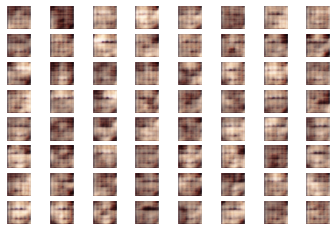

>2, 390/390, d1=0.228, d2=0.206, g=3.294


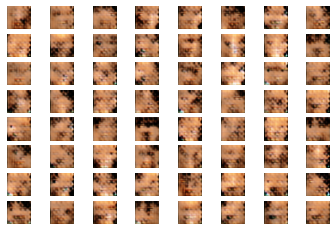

>3, 390/390, d1=0.266, d2=0.395, g=3.321


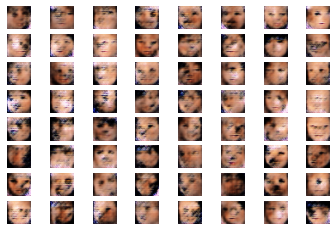

>4, 390/390, d1=0.320, d2=0.367, g=4.375


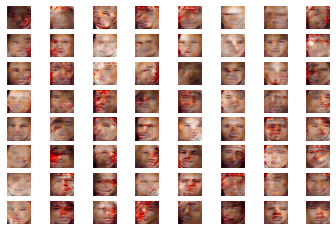

>5, 390/390, d1=0.434, d2=0.359, g=4.078


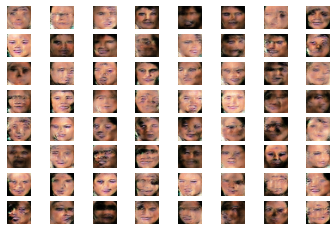

>6, 390/390, d1=0.312, d2=0.188, g=3.685


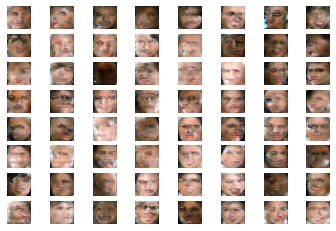

>7, 390/390, d1=0.362, d2=0.268, g=2.888


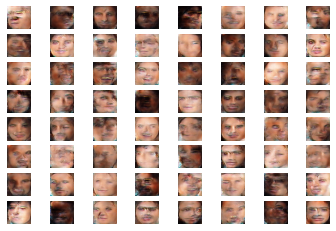

>8, 390/390, d1=0.274, d2=0.254, g=3.695


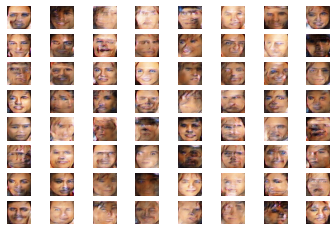

>9, 390/390, d1=0.405, d2=0.316, g=3.496


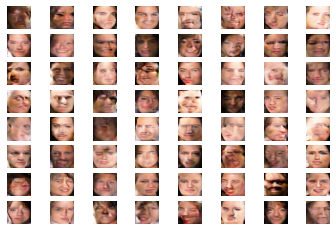

>10, 390/390, d1=0.249, d2=0.328, g=2.911


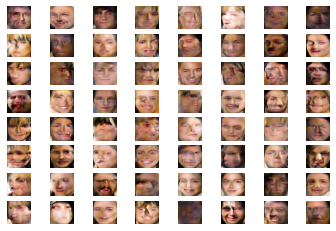

4/4 [==============================] - 0s 11ms/step - loss: 0.1715 - accuracy: 0.9700
>Accuracy real: 80%, fake: 97%
>11, 390/390, d1=0.462, d2=0.233, g=2.413


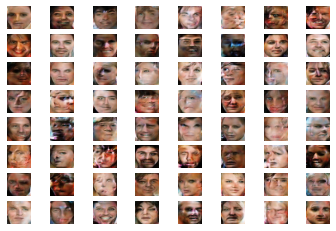

>12, 390/390, d1=0.540, d2=0.348, g=2.877


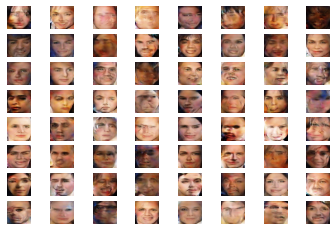

>13, 390/390, d1=0.328, d2=0.494, g=3.070


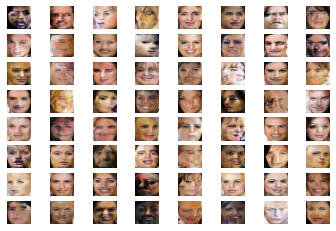

>14, 390/390, d1=0.380, d2=0.452, g=2.527


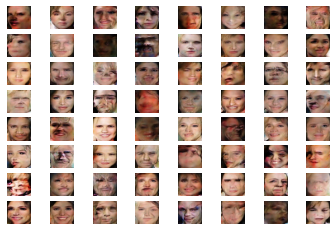

>15, 390/390, d1=0.514, d2=0.419, g=2.430


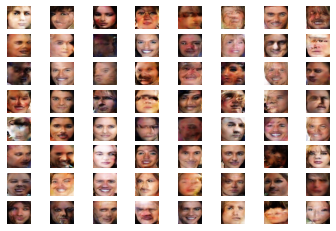

>16, 390/390, d1=0.522, d2=0.457, g=2.424


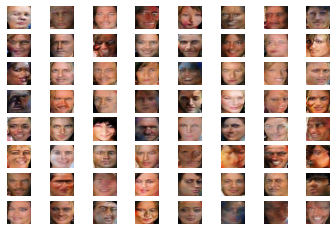

>17, 390/390, d1=0.536, d2=0.414, g=1.831


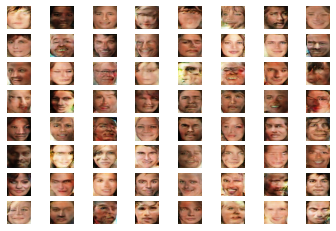

>18, 390/390, d1=0.493, d2=0.340, g=1.793


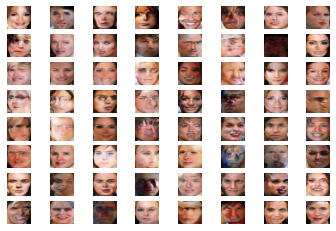

>19, 390/390, d1=0.373, d2=0.390, g=1.790


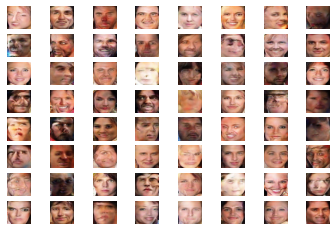

>20, 390/390, d1=0.383, d2=0.524, g=2.049


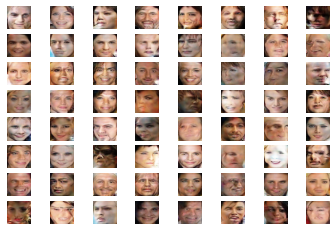

4/4 [==============================] - 0s 11ms/step - loss: 0.2868 - accuracy: 0.9100
>Accuracy real: 68%, fake: 91%
>21, 390/390, d1=0.415, d2=0.443, g=1.877


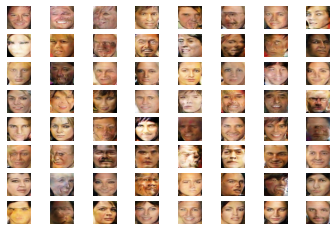

>22, 390/390, d1=0.352, d2=0.433, g=1.986


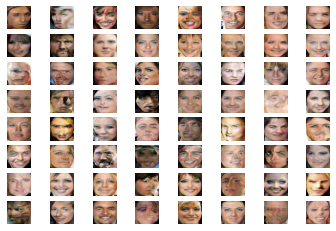

>23, 390/390, d1=0.369, d2=0.558, g=2.330


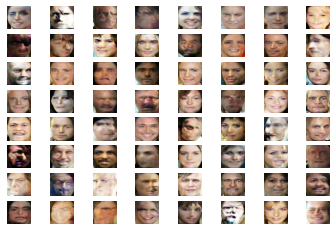

>24, 390/390, d1=0.626, d2=0.373, g=2.002


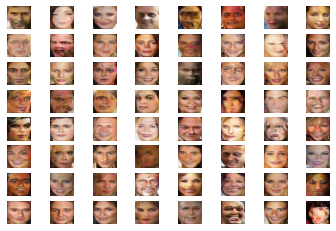

>25, 390/390, d1=0.639, d2=0.624, g=2.133


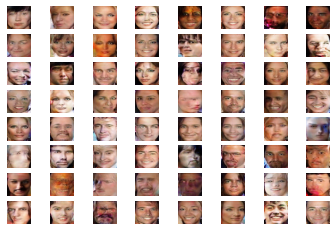

>26, 390/390, d1=0.372, d2=0.365, g=2.242


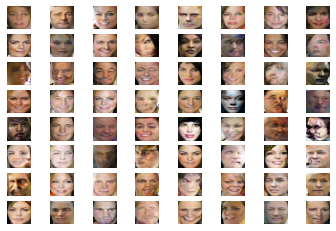

>27, 390/390, d1=0.439, d2=0.356, g=2.194


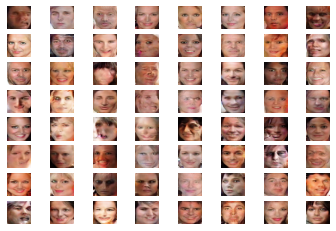

>28, 390/390, d1=0.495, d2=0.819, g=2.197


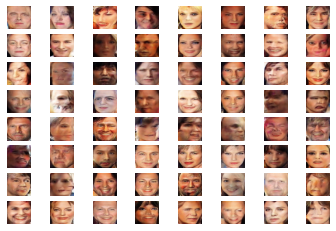

>29, 390/390, d1=0.480, d2=0.542, g=2.285


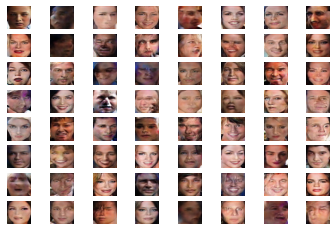

>30, 390/390, d1=0.640, d2=0.541, g=2.202


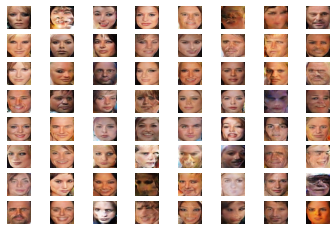

4/4 [==============================] - 0s 10ms/step - loss: 0.2881 - accuracy: 0.9500
>Accuracy real: 83%, fake: 95%
>31, 390/390, d1=0.306, d2=0.476, g=2.039


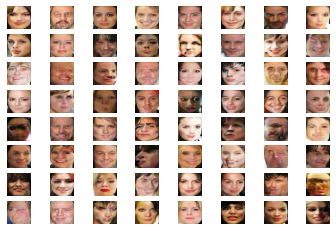

>32, 390/390, d1=0.498, d2=0.466, g=2.037


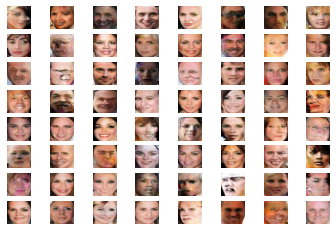

>33, 390/390, d1=0.453, d2=0.485, g=2.439


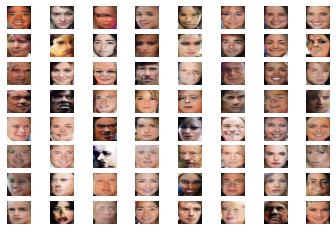

>34, 390/390, d1=0.506, d2=0.404, g=2.037


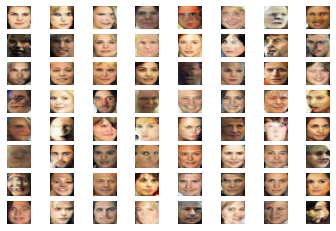

>35, 390/390, d1=0.491, d2=0.448, g=2.079


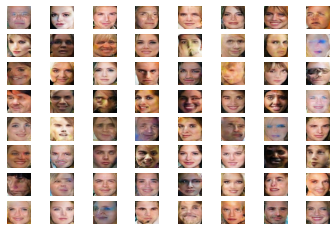

>36, 390/390, d1=0.629, d2=0.318, g=2.400


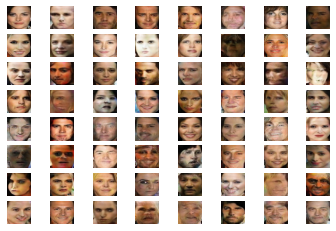

>37, 390/390, d1=0.342, d2=0.409, g=2.498


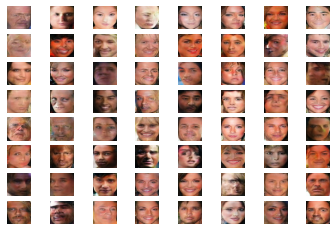

>38, 390/390, d1=0.440, d2=0.315, g=2.243


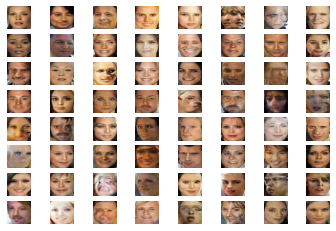

>39, 390/390, d1=0.339, d2=0.353, g=2.323


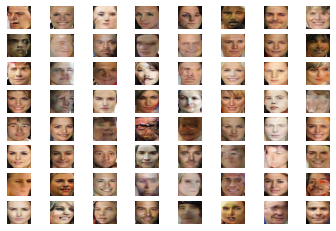

>40, 390/390, d1=0.323, d2=0.270, g=2.934


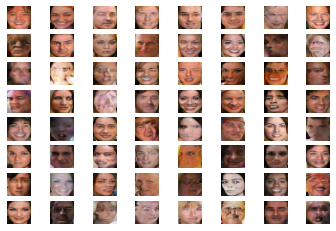

4/4 [==============================] - 0s 10ms/step - loss: 0.1594 - accuracy: 0.9800
>Accuracy real: 82%, fake: 98%
>41, 390/390, d1=0.483, d2=0.280, g=2.608


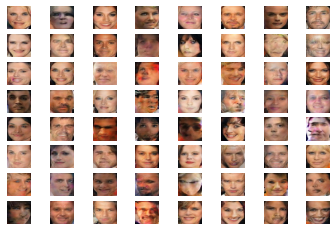

>42, 390/390, d1=0.303, d2=0.197, g=2.508


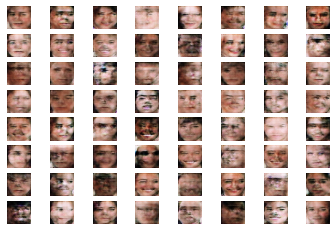

>43, 390/390, d1=0.399, d2=0.359, g=2.366


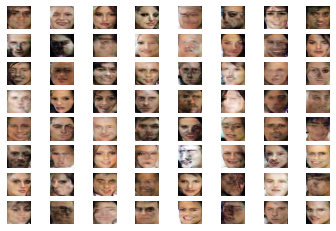

>44, 390/390, d1=0.452, d2=0.265, g=2.256


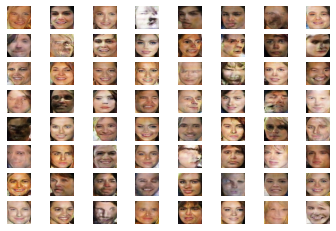

>45, 390/390, d1=0.399, d2=0.451, g=2.608


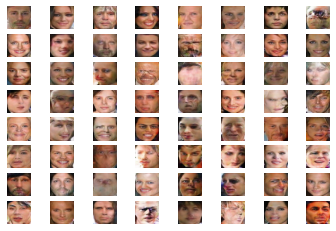

>46, 390/390, d1=0.374, d2=0.314, g=2.753


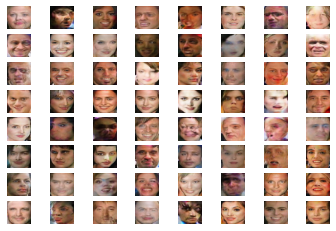

>47, 390/390, d1=0.276, d2=0.263, g=3.278


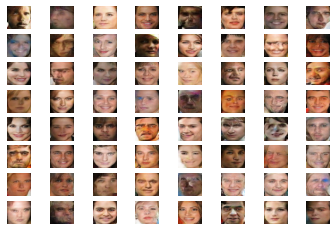

>48, 390/390, d1=0.537, d2=0.340, g=2.374


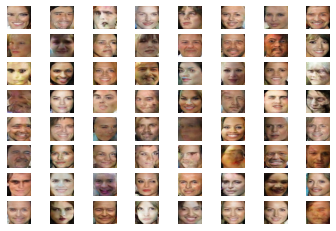

>49, 390/390, d1=0.315, d2=0.224, g=2.918


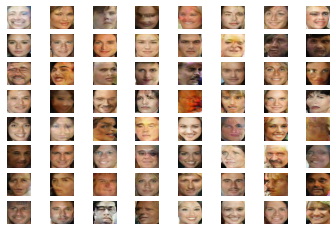

>50, 390/390, d1=0.410, d2=0.392, g=2.916


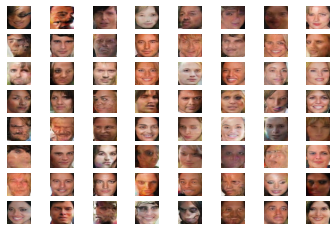

4/4 [==============================] - 0s 10ms/step - loss: 0.1100 - accuracy: 0.9900
>Accuracy real: 79%, fake: 99%
>51, 390/390, d1=0.401, d2=0.268, g=3.079


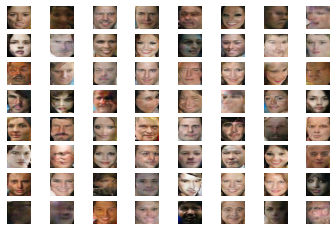

>52, 390/390, d1=0.433, d2=0.268, g=2.865


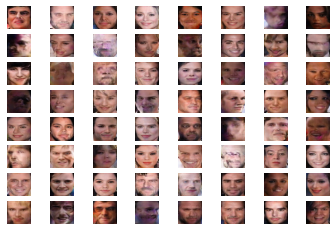

>53, 390/390, d1=0.358, d2=0.288, g=2.774


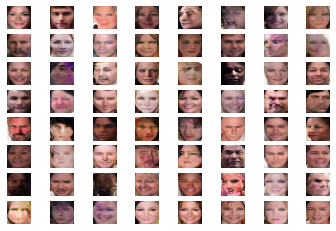

>54, 390/390, d1=0.313, d2=0.197, g=2.877


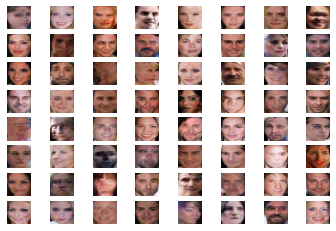

>55, 390/390, d1=2.297, d2=4.467, g=11.042


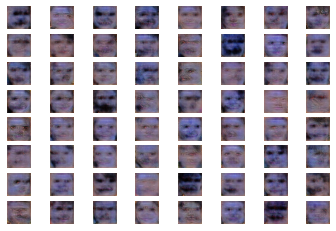

>56, 390/390, d1=0.525, d2=0.376, g=1.725


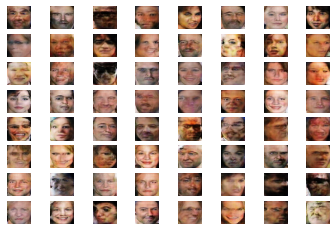

>57, 390/390, d1=0.354, d2=0.160, g=2.710


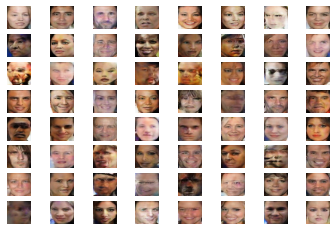

>58, 390/390, d1=0.330, d2=0.235, g=2.453


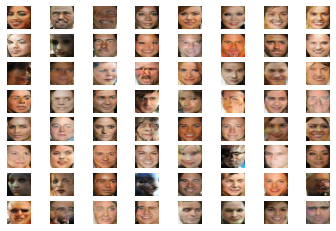

>59, 390/390, d1=0.357, d2=0.381, g=2.485


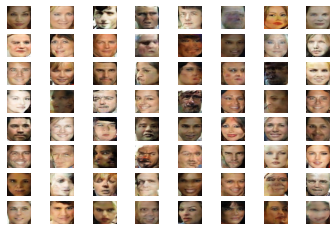

>60, 390/390, d1=0.255, d2=0.285, g=2.821


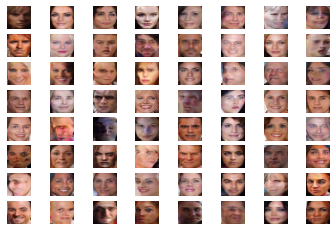

4/4 [==============================] - 0s 10ms/step - loss: 0.1195 - accuracy: 0.9900
>Accuracy real: 89%, fake: 99%


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)